In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.core.expr.numvalue.NumericValue import *
from datetime import datetime,timedelta
import pickle
import json
from sklearn.cluster import KMeans
import logging
pd.set_option('display.max_columns', None)  # or specify a number if you want a limit
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# from sklearn import metrics
# from scipy.spatial.distance import cdist
# from sklearn.preprocessing import StandardScaler

In [2]:
# Basic Setting
grid = "369_0"
next_two = True # True consider next 2 trips,False consider only next 1 trip
#date_offset = 3 # date off set between mobility data year and the day_start_ts date
scenario_year = 2050
weekday_dict = {'Monday':(1,3), 'Tuesday':(1,4),'Wednesday':(1,5),'Thursday':(1,6),'Friday':(1,7),'Saturday':(1,8),'Sunday':(1,9)}
day_start_ts = pd.to_datetime(f"{scenario_year}-01-07 00:00:00")
day_start = day_start_ts.day
day_end_ts = pd.to_datetime(f"{scenario_year}-01-08 00:00:00")
monitor_hr = int((day_end_ts - day_start_ts).total_seconds()/3600)
path = f"{grid}/{scenario_year}_Friday_2trip_30par"
participate_rate = 1  # 1 no constraints on participation rate, parking event based, not vehicle based
min_power_level = 0.5 # 1 constant power request at max. charger power, otherwise set a lower limit on power requested: min_power_level * max_power
print(monitor_hr)
# Calculate the number of groups
num_groups = 40

24


In [3]:
# Data Preprocessing
def calculate_next_trip_e(row):
    if next_two and (row['next_SoE_bc']+(row['next_parking_time']//60*7) < row['next_2_travel_TP1_consumption']): # if charge with 7 KW during whole next pakring event could not cover energy requirement for the second next trip charge the part that could not be covered within this parking event
        next_trip_e = row['next_travel_TP1_consumption']+ row['next_2_travel_TP1_consumption'] - row['next_SoE_bc']+(row['next_parking_time']//60*7)#row['next_2_travel_TP1_consumption']
    else:
        next_trip_e =  row['next_travel_TP1_consumption']
    return next_trip_e

def get_hour_index(ts):
    idx = int(divmod((ts-day_start_ts).total_seconds(),3600)[0]) 
    return idx

def get_soe_init(SoE_bc,arr_idx):
    if arr_idx<=0:
        arr_idx = 1
    soe_init_list = [0]*monitor_hr
    for idx in range(arr_idx):
        soe_init_list[idx] = SoE_bc
    return soe_init_list


def create_dict(start_ts,end_ts,start_hour_idx,end_hour_idx):
    # if end_hour_idx>monitor_hr-1:
    #     end_hour_idx = monitor_hr-1
    dict = [0]*monitor_hr
    for hour in range(monitor_hr):
        if start_hour_idx<hour and end_hour_idx>hour:
            dict[hour] = 60
        elif start_hour_idx==hour and end_hour_idx==hour:
            dict[hour] = end_ts.minute-start_ts.minute
        elif start_hour_idx<hour and end_hour_idx==hour:
            dict[hour] = end_ts.minute
        elif start_hour_idx==hour and end_hour_idx>hour:
            dict[hour] = 60-start_ts.minute
    return dict

def create_charge_time_list(charge_decision, start_ts, end_ts, start_hour_idx,end_hour_idx):
    # if end_hour_idx>monitor_hr-1:
    #     end_hour_idx = monitor_hr-1
    dict = [0]*monitor_hr
    if charge_decision:
        for hour in range(monitor_hr):
            if start_hour_idx<hour and end_hour_idx>hour:
                dict[hour] = 60
            elif start_hour_idx==hour and end_hour_idx==hour:
                dict[hour] = end_ts.minute-start_ts.minute
            elif start_hour_idx<hour and end_hour_idx==hour:
                dict[hour] = end_ts.minute
            elif start_hour_idx==hour and end_hour_idx>hour:
                dict[hour] = 60-start_ts.minute
    return dict
# Data Postprocessing
def get_timestamp_pair(row):
    process = {}
    process_key = ()
    power = []
    for hour in range(monitor_hr):
        p_t = row['optimized_power_list'][hour]
        min_t = row['hourly_time_dict'][hour]
        if hour>0:
            min_pre, p_pre = row['hourly_time_dict'][hour-1],row['optimized_power_list'][hour-1]
        else: 
            min_pre,p_pre = 0,0
        if hour<(monitor_hr-1):
            min_next, p_next = row['hourly_time_dict'][hour+1],row['optimized_power_list'][hour+1]
        else:
            min_next, p_next = 0,0
        if p_pre==0 and p_t!=0:
            if (min_t == 60 or min_pre==60) and (hour!=row['arr_time_idx']):
                start_min = 0
            elif (min_t<60 and min_pre!=60 and min_t>0) and (hour!=row['arr_time_idx']):
                start_min = 60-min_t
            elif (hour==row['arr_time_idx']):
                start_min = row['arr_time'].minute
            else:
                start_min = 0

            start_delta_hr = day_start_ts + timedelta(hours=hour)
            start_ts = pd.Timestamp(datetime(year=start_delta_hr.year,month=start_delta_hr.month,day=start_delta_hr.day,hour=start_delta_hr.hour,minute=start_min))
            process_key = (start_ts,)
        if p_t!=0:
            power.append(p_t)
        if p_next==0 and p_t!=0:
            if (min_t==60 or min_next>0) and (hour!=row['park_end_time_idx']):
                end_min=59
            elif (min_t<60 and min_next==0 and min_pre>0) and (hour!=row['park_end_time_idx']):
                end_min=min_t
            elif (hour==row['park_end_time_idx']):
                end_min=row['park_end_time'].minute
            else:
                end_min = 0

            end_delta_hr = day_start_ts + timedelta(hours=hour)
            end_ts = pd.Timestamp(datetime(year=end_delta_hr.year,month=end_delta_hr.month,day=end_delta_hr.day,hour=end_delta_hr.hour,minute=end_min))

            process_key = process_key + (end_ts,)
            process[process_key] = power
            process_key = ()
            power = []
    return process

def check_outside(row):
    if (row['process_cnt']==0) and (row['st_chg_time']==row['ed_chg_time']):
        return False
    elif row['process_cnt']>=1 and (((next(iter(row['process_list'].keys())))[0]>=row['ed_chg_time']) or ((next(iter(row['process_list'].keys())))[1]<=row['st_chg_time'])):
        return False
    else:
        return True

In [6]:
df = pd.read_csv("/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/grid369_mobility_dataset.csv")
for col in ['dep_time','arr_time','st_chg_time','ed_chg_time']:
    df[col] = pd.to_datetime(df[col],format='mixed')
df['chg_time'] = pd.to_timedelta(df['ed_chg_time']-df['st_chg_time'],unit='m')

# df['dep_time'] = df['dep_time'] + pd.DateOffset(days=date_offset)
df['dep_time'] = df.apply(lambda row:row['dep_time'].replace(year=scenario_year,month=weekday_dict[row['type_day']][0],day=weekday_dict[row['type_day']][1]), axis=1)
df['dep_time_idx'] = df.apply(lambda x:get_hour_index(x['dep_time']),axis=1)

df['arr_time'] = df['dep_time'] + pd.to_timedelta(df['trav_time'], unit='m')
df['arr_hour'] = df['arr_time'].dt.hour
df['arr_time_idx'] = df.apply(lambda x:get_hour_index(x['arr_time']), axis=1)
df['arr_day'] = df['arr_time'].dt.day

df['park_end_time'] = df['arr_time']+pd.to_timedelta(df['parking_time'],unit='m')
df['park_end_hour'] = df['park_end_time'].dt.hour
df['park_end_time_idx'] = df.apply(lambda x:get_hour_index(x['park_end_time']), axis=1)
df['park_end_day'] = df['park_end_time'].dt.day

df['st_chg_time']=df['arr_time']
# df['st_chg_time'] = df.apply(lambda row: row['st_chg_time'].replace(day=row['arr_time'].day, month=row['arr_time'].month, year=row['arr_time'].year), axis=1)
# df['st_chg_time'] = df['st_chg_time']+pd.DateOffset(days=date_offset)
# df['st_chg_time'] = df.apply(lambda row:row['st_chg_time'].replace(year=scenario_year), axis=1)
df['st_chg_time_idx'] = df.apply(lambda x:get_hour_index(x['st_chg_time']),axis=1)
df['ed_chg_time'] = df['st_chg_time']+df['chg_time']
df['ed_chg_time_idx'] = df.apply(lambda x:get_hour_index(x['ed_chg_time']),axis=1)
df['chg_time'] = df['chg_time'].dt.total_seconds()/60

df.sort_values(by=['person','dep_time'])
df_byperson = df.groupby('person')
df['next_travel_TP1_consumption'] = df_byperson['TP1 consumption kWh'].shift(-1).fillna(0)
df['next_parking_time'] = df_byperson['parking_time'].shift(-1).fillna(0)
df['next_2_travel_TP1_consumption'] = df_byperson['TP1 consumption kWh'].shift(-2).fillna(0)
df['next_SoE_bc'] = df_byperson['SoE_bc'].shift(-1).fillna(0)
df['next_trip_e'] = df.apply(calculate_next_trip_e,axis=1)



df.drop(['next_parking_time', 'next_travel_TP1_consumption', 'next_2_travel_TP1_consumption', 'TP1 rate kWh/100 km',
         'TP2 rate kWh/100 km', 'TP2 consumption kWh',
         'TP3 rate kWh/100 km', 'TP3 consumption kWh', 'TP4 rate kWh/100 km',
         'TP4 consumption kWh', 'st_mun_name', 'st_canton_name', 'st_urb_type',
         'st_mnt_type', 'ed_mun_name', 'ed_canton_name', 'ed_urb_type',
         'ed_mnt_type', 'Yearly kWh'], axis=1, inplace=True)


d = df[(df['park_end_time']>=day_start_ts) & (df['arr_time']<day_end_ts)].copy()
d['hourly_time_dict'] = d.apply(lambda x:create_dict(x.arr_time,x.park_end_time,x.arr_time_idx,x.park_end_time_idx), axis =1)
d['charge_time_list'] = d.apply(lambda x:create_charge_time_list(x.c,x.st_chg_time,x.ed_chg_time,x.st_chg_time_idx,x.ed_chg_time_idx), axis=1)
d['charge_power_list'] = d.apply(lambda x: [x['chg rate'] if t >30 else 0 for t in x['charge_time_list']], axis=1)
d['charge_power_list_sanity'] = d.apply(lambda x: [x['chg rate'] if t >0 else 0 for t in x['charge_time_list']], axis=1)
d['charge_energy_list'] = d.apply(lambda x:[t/60*x['chg rate']for t in x['charge_time_list']], axis=1)
d['charge_energy_sum'] = d['charge_energy_list'].apply(sum)
# d['is_first'] = ~d.duplicated(subset='person', keep='first')
# d['is_first'] = d['is_first'].astype(bool)
d['augmented_SoE_bc'] = np.where((d['st_chg_time']<day_start_ts)&(d['ed_chg_time']>day_start_ts),d['SoE_ac']-d['charge_energy_sum'],d['SoE_bc'])
d['soe_init'] = d.apply(lambda x:get_soe_init(x.augmented_SoE_bc,x.arr_time_idx), axis=1)
# d['max_chg_e'] = d['B']-d['augmented_SoE_bc']
d['real_chg_e'] = d['SoE_ac']-d['augmented_SoE_bc']
d.insert(0,'event_index',d.index)
d.to_pickle(f'{path}/grid_{grid}_{scenario_year}_{day_start_ts}_{monitor_hr}_preprocessed_2trip.pkl')


In [3]:
with open(f'{path}/grid_{grid}_{scenario_year}_{day_start_ts}_{monitor_hr}_preprocessed_2trip.pkl','rb') as d:
    d = pickle.load(d)

In [4]:
# Step 1: Calculate aggregates for arr_hour and dep_hour for each person_id
times = d.groupby('person').agg({
    'arr_time_idx':['min','max'],
    'dep_time_idx':['min','max']
}).reset_index()
# Flatten the MultiIndex for columns created by aggregation
times.columns = ['_'.join(col).strip('_') for col in times.columns.values]
# Create a feature dataframe for clustering
feature_df = times[['arr_time_idx_min', 'arr_time_idx_min', 'dep_time_idx_min', 'dep_time_idx_max']]

# Step 2: Cluster based on behavior
kmeans = KMeans(n_clusters=30, random_state=42).fit(feature_df)
times['cluster'] = kmeans.labels_
# Assign cluster labels to each person
clustered = pd.merge(d, times[['person', 'cluster']], on='person')
clustered = clustered.sort_values(by=['person','dep_time_idx','cluster'])
# Get unique persons and the start index for each person
unique_persons = clustered['person'].unique()
person_start_index = {person: i for i, person in enumerate(unique_persons)}


# Create a dictionary to hold the group number for each person
person_to_group = {}
# Assign groups in a round-robin fashion
group_number = 1
for person in unique_persons:
    person_to_group[person] = group_number
    group_number = group_number % num_groups + 1  # Loop back to 1 after reaching num_groups
# Now assign the group to each row in the DataFrame based on the 'person' column
clustered['group'] = clustered['person'].map(person_to_group)
clustered.drop(['cluster'],axis=1,inplace=True)

# clustered['pre_ed_chg_time'] = clustered.groupby(['group', 'person', 'grid'],dropna=False)['ed_chg_time'].shift(1)
# clustered['pre_c'] = clustered.groupby(['group','person', 'grid'],dropna=False)['c'].shift(1).fillna(False)
clustered['pre_SoE_ac'] = clustered.groupby(['group','person', 'grid'],dropna=False)['SoE_ac'].shift(1).fillna(clustered['augmented_SoE_bc'])
clustered['SoE_change'] = clustered['pre_SoE_ac']-clustered['augmented_SoE_bc']
'''
# # clustered['shifted_SoE_bc'] = clustered.groupby(['group', 'person', 'grid'],dropna=False)['augmented_SoE_bc'].shift(1).fillna(clustered['augmented_SoE_bc'])
# # Initialize 'SoE_change' column
# # clustered['SoE_change'] = np.where(
# #     (clustered['pre_c']) & (clustered['pre_ed_chg_time']>day_start_ts),
# #     clustered['shifted_SoE_bc']-clustered['augmented_SoE_bc'],
# #     clustered['shifted_SoE_ac']-clustered['augmented_SoE_bc']
# # )
'''
clustered.drop(['pre_SoE_ac'],axis=1)
clustered.set_index('event_index', inplace=True)
clustered.to_pickle(f'{path}/grid_{grid}_{scenario_year}_{day_start_ts}_{monitor_hr}_2trip_clustered.pkl')


In [4]:
# Normalize Tobia's Nexus Output
hv_bus = str(89)
# Controlled charging
charge = pd.read_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/extracted_data/map_bus/Added_up_charge_{scenario_year}_raw.csv") # in MW
charge['ts'] = pd.to_datetime(charge['ts'])
charge = charge.loc[(charge.ts<day_end_ts) & (charge.ts>=day_start_ts)][['ts','peak',hv_bus]]
# Controlled discharging
discharge = pd.read_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/extracted_data/map_bus/EVBatt_power_hourly_{scenario_year}_discharge_mapped.csv")
discharge = discharge.rename(columns={'Unnamed: 0':'ts'})
discharge['ts'] = pd.to_datetime(discharge['ts'])
discharge = discharge.loc[(discharge.ts<day_end_ts) & (discharge.ts>=day_start_ts)][['ts',hv_bus]]
# Find Netload Max
net= charge['89']-discharge['89']
period_max = net.max()
charge['normalized_profile'] = charge[hv_bus]/period_max
charge.index=range(monitor_hr)
discharge['normalized_profile'] = discharge[hv_bus]/period_max
discharge.index=range(monitor_hr)
net = charge['89']-discharge['89']
net_normalized = net/period_max
print(len(net_normalized))

24


In [14]:
def opt_charge_profile(charge,discharge,net_normalized,cluster,emob_max_p,normalized_tot_e,cluster_i,path):
    M=1000000
    t_list = list(range(monitor_hr))
    e_list = list(cluster.index)
    p_list = list(cluster['person'].unique())
    tomatch_c = charge['normalized_profile']
    tomatch_d = discharge['normalized_profile']
    tomatch_net = net_normalized


    m = ConcreteModel()
    ############################
    # Set
    m.E = Set(initialize=e_list) # parking event set
    m.T = Set(initialize=t_list) # hour of the day
    m.P = Set(initialize=p_list) #list of person
    ############################
    # Decision Variable
    m.charge_power = Var(m.E, m.T,within=NonNegativeReals,bounds=(0,1.5),initialize=0) 
    m.discharge_power = Var(m.E,m.T,within=NonNegativeReals,bounds=(0,1),initialize=0)
    
    m.is_charging = Var(m.E,m.T,within=Binary,initialize=0)
    m.is_discharging = Var(m.E,m.T,within=Binary,initialize=0)
    m.is_active = Var(m.E,within=Binary,initialize=0)
    m.charge_jump = Var(m.E,m.T, within=Binary,initialize=0) # detect charge jump
    m.discharge_jump = Var(m.E,m.T, within=Binary,initialize=0) # detect discharge jump
    m.flex_flag = Var(m.P, within=Binary,initialize=0) # detect flexibility for each person
    m.abs_power_diff_sign = Var(m.E,m.T, within=Binary,initialize=0)#

    
    # Slack Variable
    # m.charge_power_limit_s = Var(m.E, m.T, within=NonNegativeReals,initialize=0)
    # m.discharge_power_limit_s = Var(m.E, m.T, within=NonNegativeReals, initialize=0)
    m.energy_surplus = Var(within=NonNegativeReals)#,bounds=(0,0.3*normalized_tot_e)
    m.energy_deficit = Var(within=NonNegativeReals)#,bounds=(0,0.3*normalized_tot_e)
    m.ev_nonnegative_slack = Var(m.P,m.T,within=NonNegativeReals)
    m.next_trip_slack = Var(m.P,m.T,within=NonNegativeReals,bounds=(0,120/emob_max_p),initialize=0)
    m.cap_le_slack = Var(m.P,m.T,within=NonNegativeReals,initialize=0)
    
    # Auxiliary Variable
    m.tot_charge_z = Var(m.T, within=NonNegativeReals, initialize=0)
    m.tot_discharge_z = Var(m.T, within=NonNegativeReals, initialize=0)
    m.abs_power_diff = Var(m.E,m.T,within=NonNegativeReals,initialize=0)

    ###########################
    # Parameters
    m.event_cnt = Param(initialize=len(e_list))
    m.person_cnt = Param(initialize=len(p_list))

    person_id = {e:cluster.loc[e,'person'] for e in e_list}
    m.person_id = Param(m.E,initialize=person_id)
    

    first_SoE_bc_list = cluster.groupby('person')['start_SoE'].first()
    ev_soe = {p:first_SoE_bc_list[p]/emob_max_p for p in p_list}
    m.ev_soe = Param(m.P, initialize=ev_soe, within=NonNegativeReals)
    
    load_c = {t:tomatch_c[t] for t in t_list}
    m.charge_to_match = Param(m.T,initialize=load_c) # Normalized nexus profile
    
    load_d = {t:tomatch_d[t] for t in t_list}
    m.discharge_to_match = Param(m.T,initialize=load_d) # Normalized nexus profile

    power_dict = {(e,t):cluster.loc[e,'charge_power_list_sanity'][t] for e in e_list for t in t_list}
    m.unshifted_power = Param(m.E, m.T,initialize=power_dict)
    
    capacity_list = cluster.groupby('person')['B'].first()
    # capacity_e = {e:cluster.loc[e,'B']/emob_max_p for e in e_list}
    # m.capacity_e = Param(m.E,initialize=capacity_e) # Normalized battery capacity
    capacity_p = {p:capacity_list[p]/emob_max_p for p in p_list}
    m.capacity_p = Param(m.P, initialize=capacity_p)
    
    max_power_dict = {e:cluster.loc[e,'normalized_chg_power'] for e in e_list} # max charge rate at normalized scale
    m.max_power = Param(m.E,initialize=max_power_dict) # unit kW
    
    parking_time_dict = {(e,t):cluster.loc[e,'hourly_time_dict'][t]/60 for e in e_list for t in t_list}
    m.parking_time = Param(m.E,m.T,initialize=parking_time_dict) # parking minutes within this hour
    
    next_trip_e_dict = {e:cluster.loc[e,'next_trip_e']/emob_max_p for e in e_list}
    m.next_trip_e = Param(m.E,initialize=next_trip_e_dict) # normalized energy next trip requires
    
    park_end_time_idx = {e:cluster.loc[e,'park_end_time_idx'] for e in e_list}
    m.park_end_time_idx = Param(m.E, initialize=park_end_time_idx)

    arr_time_idx = {e:cluster.loc[e,'arr_time_idx'] for e in e_list}
    m.arr_time_idx = Param(m.E, initialize=arr_time_idx)
    
    SoE_change = {e:cluster.loc[e,'SoE_change']/emob_max_p for e in e_list}
    m.SoE_change = Param(m.E, initialize=SoE_change)
    
    m.unshifted_daily_energy = Param(initialize=normalized_tot_e)
    
    ############################
    # enforce is_charging=1 if charging, 0 if discharging/no action
    def positive_charge_power_rule_1(m, e, t):
        return m.charge_power[e, t] <= 1000000 * m.is_charging[e, t]
    m.positive_charge_power_con = Constraint(m.E, m.T, rule=positive_charge_power_rule_1)

    # enforce is_discharging=1 if discharging, 0 if charging/no action
    def negative_charge_power_rule(m, e, t):
        return m.discharge_power[e, t] <= 1000000 * m.is_discharging[e, t]
    m.negative_charge_power_con = Constraint(m.E, m.T, rule=negative_charge_power_rule)
    # avoid simultaneous charge and discharge
    def non_simultaneous_rule(m, e, t):
        return m.is_charging[e, t] + m.is_discharging[e, t] <= 1
    m.non_simultaneous_con = Constraint(m.E, m.T, rule=non_simultaneous_rule)


    '''
    charging power limit
    '''
    # charge/discharge power slightly deviate from max charge power
    def charge_power_limit_rule(m,e,t):
        return  m.charge_power[e, t]  <= m.max_power[e] * m.is_charging[e,t] # + m.charge_power_limit_s[e,t]
    m.power_limit_c = Constraint(m.E, m.T, rule=charge_power_limit_rule)
    def discharge_power_limit_rule(m,e,t):
        return  m.discharge_power[e, t] <= m.max_power[e] * m.is_discharging[e,t] # + m.discharge_power_limit_s[e,t]
    m.power_limit_d = Constraint(m.E, m.T, rule=discharge_power_limit_rule)
    
    def charge_power_limit_s_upper_rule(m, e, t):
        return m.charge_power[e, t] >= min_power_level * m.max_power[e]*m.is_charging[e,t]
    m.charge_power_limit_s_upper = Constraint(m.E, m.T, rule=charge_power_limit_s_upper_rule)

    def discharge_power_limit_s_upper_rule(m, e, t):
        return m.discharge_power[e, t] >= min_power_level * m.max_power[e]*m.is_discharging[e,t]
    m.discharge_power_limit_s_upper = Constraint(m.E, m.T, rule=discharge_power_limit_s_upper_rule)
    

    def decreasing_charge_rule(m,e,t):
        if t>=m.arr_time_idx[e] and t<(monitor_hr-1):
            return (m.charge_power[e,t]-m.charge_power[e,t+1])*m.is_charging[e,t]>=0
        else:
            return Constraint.Skip
    m.decreasing_charge = Constraint(m.E,m.T,rule=decreasing_charge_rule)

    def decreasing_discharge_rule(m,e,t):
        if t>=m.arr_time_idx[e] and t<(monitor_hr-1):
            return (m.discharge_power[e,t]-m.discharge_power[e,t+1])*m.is_discharging[e,t]>=0
        else:
            return Constraint.Skip
    m.decreasing_discharge = Constraint(m.E,m.T,rule=decreasing_discharge_rule)
    
    def parking_rule_c(m,e,t):
        if m.parking_time[e,t]==0: 
            return m.charge_power[e,t]==0 # not parked for charge
        else:
            return Constraint.Skip
    m.parking_c = Constraint(m.E,m.T,rule=parking_rule_c)   
    def parking_rule_d(m,e,t):
        if m.parking_time[e,t]==0:
            return m.discharge_power[e,t]==0 # not parked for discharge
        else:
            return Constraint.Skip
    m.parking_d = Constraint(m.E,m.T,rule=parking_rule_d)  
    
    
    '''
    SoE non-negative and prepare for future trips constraints
    '''
    def event_charge_energy(m,e,t):
        if m.SoE_change[e]!=0 and t==m.arr_time_idx[e]:
            return -m.SoE_change[e]+(m.charge_power[e,t]-m.discharge_power[e,t])*m.parking_time[e,t] 
        else: # First or  the only event within the grid of this EV
            return (m.charge_power[e,t]-m.discharge_power[e,t])*m.parking_time[e,t] 
    m.event_charge_energy = Expression(m.E,m.T,rule=event_charge_energy)
    
    # Sum up SoE change for each EV battery from different event E at each T
    def sum_energy_per_ev(m,p,t):
        return sum(m.event_charge_energy[e,t] if m.person_id[e]==p else 0 for e in e_list)
    m.ev_charge_energy = Expression(m.P,m.T, rule=sum_energy_per_ev)
    
    # Update each EV battery' SOE at each T
    def ev_soe_update_rule(m,p,t):
        if t==0:
            return m.ev_soe[p]
        else:
            return m.ev_soe_update[p,t-1] + m.ev_charge_energy[p,t]
    m.ev_soe_update = Expression(m.P,m.T,rule=ev_soe_update_rule)

    def SoE_nonnegative_rule(m,p,t):
        return m.ev_soe_update[p,t] +m.ev_nonnegative_slack[p,t]>=0 # +m.ev_nonnegative_slack[p,t]
    m.SoE_nonnegative = Constraint(m.P,m.T,rule=SoE_nonnegative_rule)
    
    def SoE_le_capacity_rule(m,p,t):
        return m.ev_soe_update[p,t] + m.cap_le_slack[p,t]<=m.capacity_p[p] #+m.cap_le_slack[p,t]
    m.SoE_le_capacity = Constraint(m.P,m.T,rule=SoE_le_capacity_rule)

    # Prepare for next trip:
    def next_trip_min_SoE_rule(m,e,t):
        if t==m.park_end_time_idx[e]+1 and m.park_end_time_idx[e]<(monitor_hr-2):
            return m.ev_soe_update[m.person_id[e],t+1] + m.next_trip_slack[m.person_id[e],t+1]>=m.next_trip_e[e] #+ m.next_trip_slack[m.person_id[e],t+1]
        else:
            return Constraint.Skip  
    m.next_trip_min_SoE = Constraint(m.E,m.T,rule=next_trip_min_SoE_rule)
    
    '''
    Avoid alternating charging direction
    '''
    def detect_charge_jump_1(m,e,t): # Detect jump on 
        if t==0:
            # return m.charge_jump[e,t]==0
            return m.charge_jump[e,t]==1*m.is_charging[e,t]
        else:
            return m.is_charging[e,t]-m.is_charging[e,t-1] <= 100000 * m.charge_jump[e,t]
    m.detect_charge_jump_1 = Constraint(m.E,m.T,rule=detect_charge_jump_1) 

    def charge_jump_cnt(m,e):
        return sum(m.charge_jump[e,t] for t in m.T)
    m.charge_jump_cnt = Expression(m.E,rule=charge_jump_cnt)
    def charge_jump_rule(m,e):
        return m.charge_jump_cnt[e]<= 1
    m.charge_jump_rule = Constraint(m.E, rule=charge_jump_rule)
    def detect_discharge_jump_1(m,e,t): # Detect discharge jump on
        if t==0:
            return m.discharge_jump[e,t]==1*m.is_discharging[e,t]
        else:
            return m.is_discharging[e,t]-m.is_discharging[e,t-1] <= 100000 * m.discharge_jump[e,t]
    m.detect_discharge_jump_1 = Constraint(m.E,m.T,rule=detect_discharge_jump_1)

    def discharge_jump_cnt(m,e):
        return sum(m.discharge_jump[e,t] for t in m.T)
    m.discharge_jump_cnt = Expression(m.E,rule=discharge_jump_cnt)
    def discharge_jump_rule(m,e):
        return m.discharge_jump_cnt[e]<= 1
    m.discharge_jump_rule = Constraint(m.E, rule=discharge_jump_rule)
    # Either charge or discharge in one event, not allowing both
    def only_charge_or_discharge_rule(m,e):
        return m.charge_jump_cnt[e]+m.discharge_jump_cnt[e]<= 1
    m.only_1 = Constraint(m.E,rule=only_charge_or_discharge_rule)

    '''
    Min duration of charging/discharging
    '''
    def min_charge_time_rule(m, e):
        return sum(m.is_charging[e,t] * m.parking_time[e,t] + m.is_discharging[e,t] * m.parking_time[e,t] for t in m.T) >= 0.5 * m.is_active[e]
    m.min_charge_energy = Constraint(m.E, rule=min_charge_time_rule)

    '''
    Pariticipation Level Limit
    '''
    def activity_rule(m, e):
        return sum(m.is_charging[e,t] * m.parking_time[e,t] + m.is_discharging[e,t] * m.parking_time[e,t] for t in m.T) <= M * m.is_active[e]
    m.activity_constraint = Constraint(m.E, rule=activity_rule)

    # def activ_cnt_rule(m):
    #     return sum(m.is_active[e] for e in m.E)<=participate_rate * m.event_cnt
    # m.acitiv_cnt = Constraint(rule=activ_cnt_rule)

    def power_diff_abs_1_rule(m,e,t):
        return m.unshifted_power[e,t]-(m.charge_power[e,t]-m.discharge_power[e,t])<=m.abs_power_diff[e,t]
    m.power_diff_abs_1 = Constraint(m.E,m.T,rule=power_diff_abs_1_rule)

    def power_diff_abs_2_rule(m,e,t):
        return -m.unshifted_power[e,t]+(m.charge_power[e,t]-m.discharge_power[e,t])<=m.abs_power_diff[e,t]
    m.power_diff_abs_2 = Constraint(m.E,m.T,rule=power_diff_abs_2_rule)
    
    def compare_power_list_rule(m,p):
        return sum(m.abs_power_diff[e,t] if m.person_id[e]==p else 0 for e in e_list for t in t_list) <= M*m.flex_flag[p]
    m.compare_power_list = Constraint(m.P,rule=compare_power_list_rule)
    def person_active_rule(m):
        return sum(m.flex_flag[p] for p in m.P)<=0.3*m.person_cnt
    m.person_active_limit = Constraint(rule=person_active_rule)


    '''
    Net Energy Matching
    '''
    # houlry charge energy requested from the grid for all EVs of shifted profile
    def hourly_tot_net_charge_energy_rule(m,t):
        return sum((m.charge_power[e,t]-m.discharge_power[e,t])*m.parking_time[e,t] for e in m.E)
    m.hourly_tot_net_charge_energy = Expression(m.T, rule=hourly_tot_net_charge_energy_rule)

    # Net charged energy for whole day of shifted profile
    def net_charge_daily_rule(m):
        return sum(m.hourly_tot_net_charge_energy[t] for t in m.T)
    m.shifted_daily_energy = Expression(rule=net_charge_daily_rule)

    # Match shifted daily required energy with the unshifted sum
    def match_daily_energy_rule(m):
        return m.shifted_daily_energy + m.energy_deficit ==m.unshifted_daily_energy + m.energy_surplus
    m.match_daily_energy = Constraint(rule=match_daily_energy_rule)
    
    '''
    Expression for hourly aggregated power
    '''
    # hourly charge power requested from the grid for all EVs
    def hourly_tot_charge_power_rule(m,t):
        return sum(m.charge_power[e,t] * m.is_charging[e,t] for e in m.E )
    m.hourly_tot_charge_power = Expression(m.T,rule=hourly_tot_charge_power_rule)
    def mask_tot_charge_z(m,t):
        return m.tot_charge_z[t]==m.hourly_tot_charge_power[t]
    m.tot_charge = Constraint(m.T, rule=mask_tot_charge_z)
    def hourly_tot_discharge_power_rule(m,t):
        return sum(m.discharge_power[e,t]* m.is_discharging[e,t] for e in m.E)
    m.hourly_tot_discharge_power = Expression(m.T, rule=hourly_tot_discharge_power_rule)
    def mask_tot_discharge_z(m,t):
        return m.tot_discharge_z[t]==m.hourly_tot_discharge_power[t]
    m.tot_discharge = Constraint(m.T, rule=mask_tot_discharge_z)
    def hourly_tot_net_charge_power_rule(m,t):
        return sum((m.charge_power[e,t]-m.discharge_power[e,t]) for e in m.E )
    m.hourly_tot_net_charge_power = Expression(m.T,rule=hourly_tot_net_charge_power_rule)
    
    ###########################
    # Objective 
    def objective_rule(m):
        return sum((m.charge_to_match[t]-m.tot_charge_z[t])**2 for t in m.T) + 5*sum((m.discharge_to_match[t]-m.tot_discharge_z[t])**2 for t in m.T) + sum(m.ev_nonnegative_slack[p,t] for p in m.P for t in m.T) + sum(m.cap_le_slack[p,t] for p in m.P for t in m.T) + sum(m.next_trip_slack[p,t] for p in m.P for t in m.T)
        #+ sum(1*m.next_trip_slack[p,t] for p in m.P for t in m.T) + sum(1*m.ev_nonnegative_slack[p,t] for p in m.P for t in m.T) + sum(1*m.cap_le_slack[p,t]for p in m.P for t in m.T)
    m.objective = Objective(rule=objective_rule, sense=minimize)

    ###########################
    # Solve model
    solver = SolverFactory('gurobi')
    solver.options['FeasibilityTol'] = 1e-2
    solver.options['OptimalityTol'] = 1e-2
    solver.options['MIPGapAbs'] = 0.5
    solver.options['NoRelHeurTime'] = 60
    # solver.options['NodeMethod'] = 2
    solver.options['MIPFocus'] = 2
    solver.solve(m,tee=True,logfile=f"{path}/cluster_{cluster_i}.log")   #,keepfiles=True,logfile="match_profile_log.log")
    logging.getLogger().setLevel(logging.INFO)
    log_infeasible_constraints(m)
    
    # Save results
    ch_dict = {(e, t): m.charge_power[e, t].value*emob_max_p for e in m.E for t in m.T} # Denormalize back to normal power value in kW
    dis_dict = {(e,t):m.discharge_power[e,t].value*emob_max_p for e in m.E for t in m.T}
    soe_dict = {(p,t):value(m.ev_soe_update[p,t]*emob_max_p) for p in m.P for t in m.T}
    person_dict = {p: m.flex_flag[p].value for p in m.P}
    abs_power_diff_dict = {(e,t):m.abs_power_diff[e,t].value*emob_max_p for e in m.E for t in m.T}
    ch = pd.Series(ch_dict).unstack()
    ch.to_csv(f'{path}/{grid}_cluster_{cluster_i}_charge.csv')
    dis = pd.Series(dis_dict).unstack()
    dis.to_csv(f'{path}/{grid}_cluster_{cluster_i}_discharge.csv')
    soe = pd.Series(soe_dict).unstack()
    soe.to_csv(f'{path}/{grid}_cluster_{cluster_i}_soe.csv')
    person_flag = pd.Series(person_dict)
    person_flag.to_csv(f"{path}/{grid}_cluster_{cluster_i}_person_participate_flag.csv")
    # abs_power_diff=pd.Series(abs_power_diff_dict).unstack()
    # abs_power_diff.to_csv(f"{path}/{grid}_cluster_{cluster_i}_power_diff.csv")
    return 0

In [6]:
with open(f"{path}/grid_{grid}_{scenario_year}_{day_start_ts}_{monitor_hr}_2trip_clustered.pkl","rb") as c:
    clustered = pickle.load(c)
clustered = clustered[clustered['grid']=='369_0']

Mobility data peak power: 213.0 Mobility data minimal power: 0 Mobility data total power: 2332.0
Mobility data peak energy: 191.45 Mobility data minimal energy: 0.55 Mobility data total energy: 2316.35


/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_28608/2382757092.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['augmented_SoE_bc'])
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_28608/2382757092.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpndm3jmz7.pyomo.lp
Reading time = 0.88 seconds
x1: 267916 rows, 166406 columns, 914719 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGapAbs to value 0.5
Set parameter NoRelHeurTime to value 60
Set parameter MIPFocus to value 2
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 267916 rows, 166406 columns and 914719 nonzeros
Model fingerprint: 0xfed6b442
Model has 48 quadratic objective terms
Model has 20490 quadratic constraints
Variable types: 87243 continuous, 79163 integer (79163 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix r

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



INFO: CONSTR SoE_nonnegative[7757207,12]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[7757207,13]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[7757207,14]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[7757207,15]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[7757207,16]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[7757207,17]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[7757207,18]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[7757207,19]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[7757207,20]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[7757207,21]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[7757207,22]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[7757207,23]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[7759184,0]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[7759184,1]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[7759184,2]: 0.0 <?= evaluation erro

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



INFO: CONSTR SoE_nonnegative[8632029,23]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[8634600,0]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[8634600,1]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[8634600,2]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[8634600,3]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[8634600,4]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[8634600,5]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[8634600,6]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[8634600,7]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[8634600,8]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[8634600,9]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[8634600,10]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[8634600,11]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[8634600,12]: 0.0 <?= evaluation error
INFO: CONSTR SoE_nonnegative[8634600,13]: 0.0 <?= evaluation error
INFO:

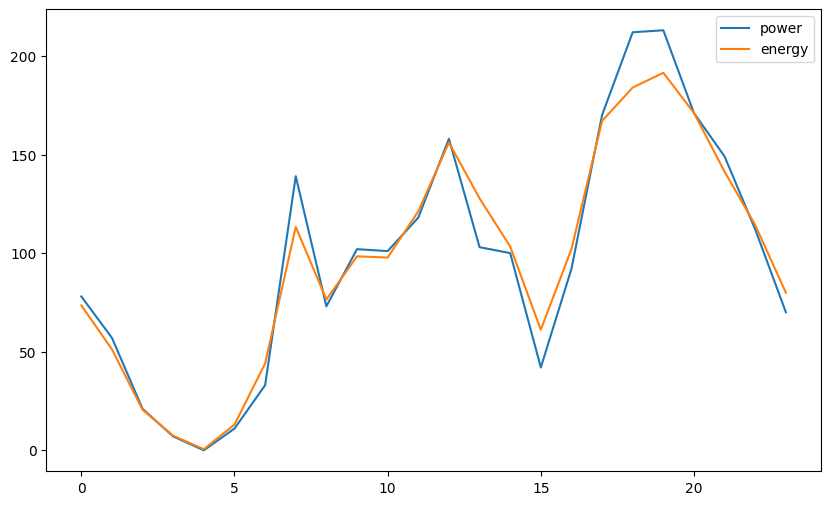

In [15]:
# Normalize the mobility aggregated charge power, calculate min, max, sum of power if there were EVs charging in the cluster then optimize this cluster's charging behavior to fit the curve
for i in [4]:#range(num_groups):
    cluster = clustered[(clustered['group']==i+1) & (clustered['grid']==grid)]
    firsts = cluster.groupby('person').agg({
        # 'c': 'first',
        # 'ed_chg_time': 'first',
        # 'SoE_ac': 'first',
        'augmented_SoE_bc': 'first'
    }).reset_index() 

    # condition = (firsts['c'] == True) & (firsts['ed_chg_time'] < day_start_ts)
    # firsts['start_SoE'] = firsts.apply(lambda x: x['SoE_ac'] if condition.loc[x.name] else x['augmented_SoE_bc'], axis=1)
    # cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['start_SoE'])

    cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['augmented_SoE_bc'])
    emob_agg_e = [sum(x) for x in zip(*cluster['charge_energy_list'])] # energy in kWh
    emob_agg_p = [sum(x) for x in zip(*cluster['charge_power_list'])] # power in kW
    
    emob_max_p, emob_min_p,emob_tot_p = max(emob_agg_p), min(emob_agg_p), sum(emob_agg_p)
    print("Mobility data peak power:",emob_max_p,"Mobility data minimal power:",emob_min_p,"Mobility data total power:",emob_tot_p)
    emob_max_e, emob_min_e, emob_tot_e= max(emob_agg_e), min(emob_agg_e),sum(emob_agg_e)
    print("Mobility data peak energy:",emob_max_e,"Mobility data minimal energy:",emob_min_e,"Mobility data total energy:",emob_tot_e)
    
    if emob_max_p!=0:
        emob_agg_p_norm =  [p/emob_max_p for p in emob_agg_p]
        plt.figure(figsize=(10,6))
        plt.plot(emob_agg_p,label='power')
        plt.plot(emob_agg_e,label='energy')
        plt.legend()
        plt.savefig(f'{path}/369_9_cluster_{i}_agg_p_e.png')
        cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p
        normalized_tot_e = emob_tot_e/emob_max_p
        opt_res_code = opt_charge_profile(charge,discharge,net_normalized,cluster,emob_max_p,normalized_tot_e,i,path)

    else:
        index = list(cluster.index)
        T = list(range(monitor_hr))
        res_dict = {(e, t):0 for e in index for t in T} # Denormalize back to normal power value in kW
        # Convert the dictionary into a multi-index series to facilitate unstacking
        res = pd.Series(res_dict).unstack()
        # Save the restructured data to CSV
        res.to_csv(f'{path}/369_0_cluster_{i}.csv')

In [ ]:
agg_e = [sum(x) for x in zip(*clustered['charge_energy_list'])] # energy in kWh
agg_p = [sum(x) for x in zip(*clustered['charge_power_list'])] # power in kW

max_p,min_p,tot_p = max(agg_p), min(agg_p),sum(agg_p)
max_e,min_e,tot_e= max(agg_e), min(agg_e),sum(agg_e)

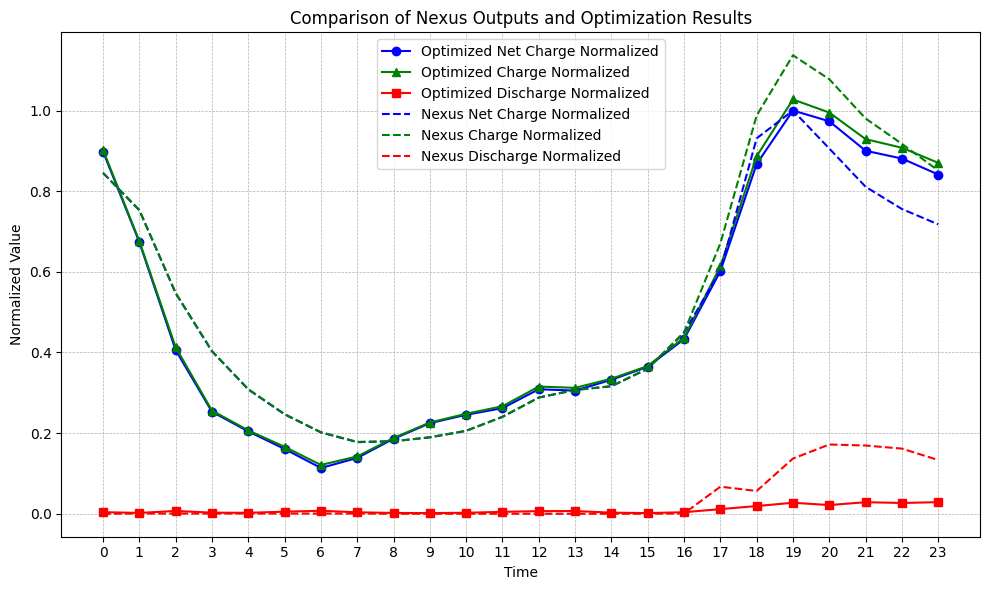

In [ ]:
concat_charge = pd.DataFrame()
concat_discharge = pd.DataFrame()
concat_soe = pd.DataFrame()
for i in range(num_groups):
    charge_i = pd.read_csv(f'{path}/{grid}_cluster_{i}_charge.csv')
    concat_charge = pd.concat([concat_charge,charge_i],axis=0)
    discharge_i = pd.read_csv(f'{path}/{grid}_cluster_{i}_discharge.csv')
    concat_discharge = pd.concat([concat_discharge,discharge_i],axis=0)
    soe_i = pd.read_csv(f'{path}/{grid}_cluster_{i}_soe.csv')
    concat_soe = pd.concat([concat_soe,soe_i],axis=0)
    
concat_charge = concat_charge.rename(columns={'Unnamed: 0':'event_index'})
concat_discharge = concat_discharge.rename(columns={'Unnamed: 0':'event_index'})
concat_soe = concat_soe.rename(columns={'Unnamed: 0':'person'})

concat_res = concat_charge-concat_discharge
concat_res.loc[:,'event_index'] = concat_charge['event_index']
concat_res.set_index('event_index', inplace=True)

# Cast to 0 is power too low
for column in concat_res.columns:
    if column != 'event_index':
        # Apply the condition and replace values
        concat_res.loc[:, column] = concat_res[column].apply(lambda x: 0 if abs(x) < 0.01 else x)
        
concat_charge.to_csv(f'{path}/concat_charge_power_all.csv')
concat_discharge.to_csv(f'{path}/concat_dicharge_power_all.csv')
concat_res.to_csv(f'{path}/concat_net_power_all.csv')
concat_soe.to_csv(f'{path}/concat_soe_all.csv')

concat_sum = concat_res.sum().sum()
concat_max = concat_res.sum().max()
plt.figure(figsize=(10, 6))

# Optimized results with solid lines and markers
plt.plot(concat_res.sum()/concat_max, label='Optimized Net Charge Normalized', color='blue', linestyle='-', marker='o')
plt.plot(concat_charge.sum()[1:]/concat_max, label='Optimized Charge Normalized', color='green', linestyle='-', marker='^')
plt.plot(concat_discharge.sum()[1:]/concat_max, label='Optimized Discharge Normalized', color='red', linestyle='-', marker='s')

# Nexus outputs with dashed lines
plt.plot(net_normalized, label='Nexus Net Charge Normalized', color='blue', linestyle='--')
plt.plot(charge['normalized_profile'], label='Nexus Charge Normalized', color='green', linestyle='--')
plt.plot(discharge['normalized_profile'], label='Nexus Discharge Normalized', color='red', linestyle='--')

plt.title('Comparison of Nexus Outputs and Optimization Results')
plt.xlabel('Time')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(f'{path}/optimized_norm_power_vs_nexus.png')
plt.show()


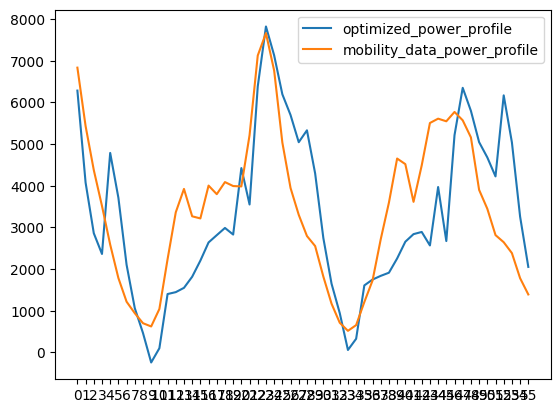

In [24]:
res_p = concat_res.sum()
plt.plot(res_p,label='optimized_power_profile')
plt.plot(agg_p, label='mobility_data_power_profile')
plt.legend()
plt.savefig(f'{path}/optimized_vs_mobility_power_profile.png')

In [25]:
concat_res = concat_res.sort_index()
time = pd.DataFrame(clustered['hourly_time_dict'].sort_index())
event_e = concat_res.apply(lambda row: [row[col]*time.at[row.name,'hourly_time_dict'][col]/60 for col in range(monitor_hr)],axis=1)

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_3125/2965137916.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  event_e = concat_res.apply(lambda row: [row[col]*time.at[row.name,'hourly_time_dict'][col]/60 for col in range(monitor_hr)],axis=1)


In [26]:
e = pd.DataFrame(event_e.tolist())
e.set_index(concat_res.index,inplace=True)
res_e = pd.Series(e.sum(),name='agg_e')
res_e_sum = res_e.sum()

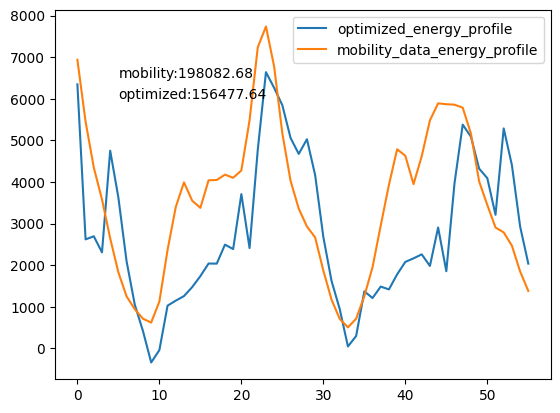

In [27]:
res_p = concat_res.sum()
# plt.plot(res_p,label='optimized_power_profile')
plt.plot(res_e,label='optimized_energy_profile')
plt.plot(agg_e,label='mobility_data_energy_profile')
plt.text(5,6500,f'mobility:{tot_e:.2f}')
plt.text(5,6000,f'optimized:{res_e_sum:.2f}')
plt.legend()
plt.savefig(f'{path}/optimized_vs_mobility_energy_profile.png')

In [28]:
res = pd.read_csv(f'{path}/concat_net_power_all.csv',index_col='event_index')
powerlist = res.apply(lambda row: row.tolist(), axis=1)
powerlist.sort_index()
soe_all = pd.read_csv(f"{path}/concat_soe_all.csv", index_col='person')
soe_end = soe_all.iloc[:,-1]
soe_end

person
448389      13.540000
456110     110.360000
458369      59.500000
465892      52.340000
468298      41.520000
503267      56.960000
691038     120.000000
2318487     53.480000
2320147     64.190000
2325841     63.580000
2330144     59.000000
2340743     64.950000
2343201     57.596667
2368088     59.050000
2371248     56.110000
2372564     54.830000
2373897     48.850000
2381738     46.980000
2386595     49.952693
2391961     59.210000
2394844     70.000000
2404796     64.740000
2411037     70.000000
2413742     44.690000
2419076     69.092206
2421908     59.070000
2456395     70.000000
2460828     59.700000
2461961     59.000000
2464217     53.040000
2466621     64.640000
2467812     63.850000
2488296     50.420000
2494436     70.000000
2497521     69.920000
2504792     48.980000
2512987     74.020000
2527924     70.000000
2535452     47.670000
2538204     63.640000
2541414     70.000000
2551859     46.130000
2555248     60.200000
2666543     85.696713
2718929     83.390000
274

In [29]:
d_in = clustered.copy()
d_in.sort_index()
d_in.loc[:,'optimized_power_list'] = powerlist
d_in.loc[:,'optimized_energy_list'] = d_in.apply(lambda row: [row['hourly_time_dict'][x]/60 * row['optimized_power_list'][x] for x in range(monitor_hr)], axis=1)
d_in['process_list'] = d_in.apply(lambda row:get_timestamp_pair(row),axis=1)
d_in['optimized_process_mean_power'] = d_in['process_list'].apply(lambda x: np.mean(next(iter(x.values())))if len(x)>0 else 0)
d_in['day_end_soe'] = d_in['person'].map(soe_end)
d_in['unshifted_day_end_soe'] = d_in.groupby('person')['SoE_ac'].transform(lambda x: x.iloc[-1])
d_in['day_end_soe_shift'] = (d_in['day_end_soe']-d_in['unshifted_day_end_soe'])/d_in['unshifted_day_end_soe']
d_in['process_cnt'] = d_in['process_list'].apply(len)
d_in['shifted_process_cnt'] = d_in.groupby('person')['process_cnt'].transform(lambda x:x.sum()) # per person
d_in['unshifted_process_cnt'] = d_in.groupby('person')['c'].transform(lambda x: x.sum()) # per person
d_in['optimized_power_list'] = d_in['optimized_power_list'].apply(lambda x: [round(float(i),1) for i in x])
d_in['charge_power_list_sanity'] = d_in['charge_power_list_sanity'].apply(lambda x: [round(float(i),1) for i in x])
d_in['flex'] = d_in['optimized_power_list'] != d_in['charge_power_list_sanity'] # per event
d_in['outside_base'] = d_in.apply(lambda row:check_outside(row), axis=1) # per event
d_in.to_pickle(f'{path}/grid_{grid}_matched_{day_start_ts}_{monitor_hr}_{scenario_year}.pkl')

In [30]:
with open(f"{path}/grid_{grid}_matched_{day_start_ts}_{monitor_hr}_{scenario_year}.pkl", "rb") as file:
    d_in = pickle.load(file)

In [31]:
d_in[d_in['day_end_soe']<0][['person','dep_time','arr_time','st_chg_time','ed_chg_time','SoE_bc','SoE_ac','day_end_soe','unshifted_day_end_soe','SoE_change','optimized_energy_list']]

,person,dep_time,arr_time,st_chg_time,ed_chg_time,SoE_bc,SoE_ac,day_end_soe,unshifted_day_end_soe,SoE_change,optimized_energy_list
event_index,,,,,,,,,,,


In [32]:
d_in[d_in['day_end_soe']-d_in['B']>4][['person','st_chg_time','ed_chg_time','SoE_bc','SoE_ac','day_end_soe','B','unshifted_day_end_soe','SoE_change','optimized_energy_list']]

,person,st_chg_time,ed_chg_time,SoE_bc,SoE_ac,day_end_soe,B,unshifted_day_end_soe,SoE_change,optimized_energy_list
event_index,,,,,,,,,,


Person/Vehicle count: 16172
Parking event count: 63094
Person/Vehicel participation count: 12270
Parking event participation count: 24687
Flexibility participation rate by person: 0.7587187731882266
Flexibility participation rate by parking event 0.39127333819380605


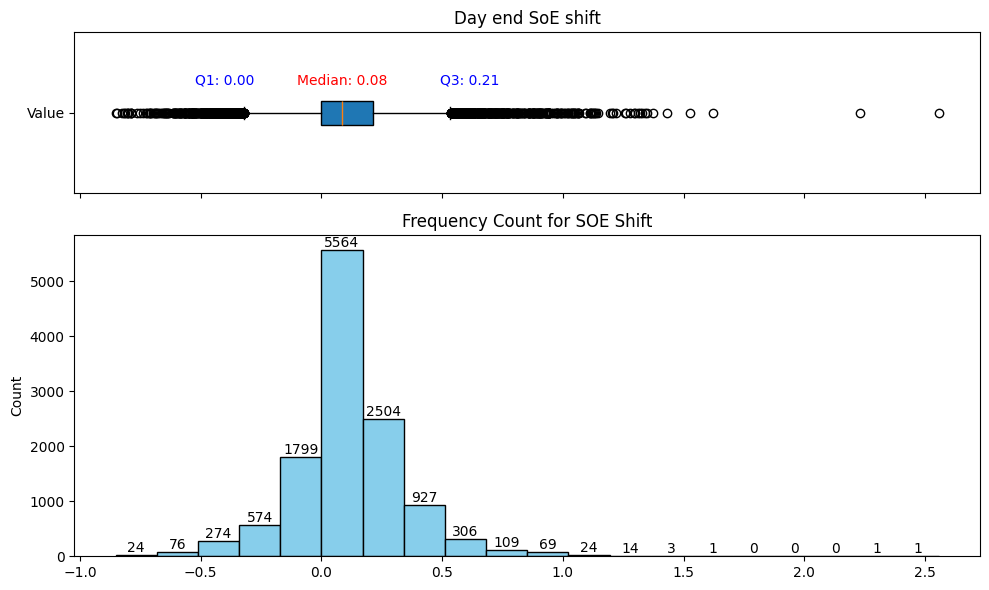

In [33]:
# Stats
# Participation rate
flex_d_in = d_in[d_in['flex']==True].copy()
print("Person/Vehicle count:", d_in['person'].nunique())
print("Parking event count:", len(d_in))
print("Person/Vehicel participation count:",flex_d_in['person'].nunique())
print("Parking event participation count:",len(flex_d_in))
print("Flexibility participation rate by person:", float(flex_d_in['person'].nunique()/d_in['person'].nunique()))
print("Flexibility participation rate by parking event", float(len(flex_d_in)/len(d_in)))


# Shifted Day End soe within EVs participated in the flexibility
soe_shift =  flex_d_in.groupby('person')['day_end_soe_shift'].first()
# Adjusting the plots to have the boxplot lying down (horizontal) for alignment with the barplot's values
fig, axs = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 2]}, sharex=True)
q1, q2, q3 = np.percentile(soe_shift, [25, 50, 75])
# Horizontal boxplot for 'soe_shift' on the top subplot
axs[0].boxplot(soe_shift, vert=False, patch_artist=True, positions=[1])
axs[0].set_title('Day end SoE shift')
axs[0].set_yticks([1])
axs[0].set_yticklabels(['Value'])
# Adding quartile labels to the boxplot
axs[0].text(q1-0.4, 1.2, f"Q1: {q1:.2f}", ha='center', va='center', fontsize=10, color='blue', backgroundcolor='white')
axs[0].text(q2, 1.2, f"Median: {q2:.2f}", ha='center', va='center', fontsize=10, color='red', backgroundcolor='white')
axs[0].text(q3+0.4, 1.2, f"Q3: {q3:.2f}", ha='center', va='center', fontsize=10, color='blue', backgroundcolor='white')

# Barplot for frequency data on the bottom subplot, aligned with the boxplot's values
counts,edges,bars = axs[1].hist(soe_shift, color='skyblue', edgecolor='black',bins=20)
# counts,edges,bars = axs[1].hist(soe_shift, color='skyblue', edgecolor='black',bins=20,density=True)
axs[1].set_title('Frequency Count for SOE Shift')
axs[1].set_ylabel('Count')
plt.bar_label(bars)
plt.tight_layout()
plt.savefig(f"{path}/sanitycheck/day_end_soeshift.png")

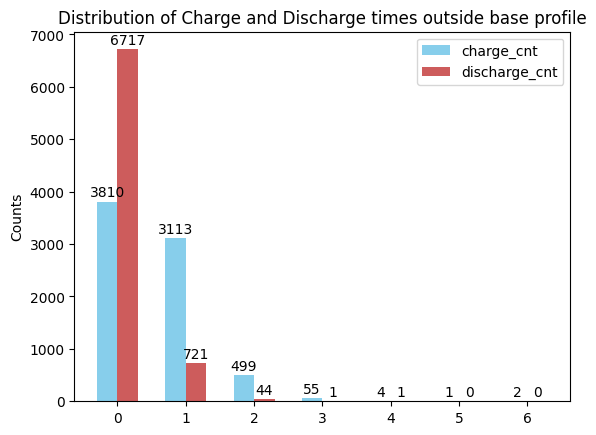

In [34]:
out_base = d_in[d_in['outside_base']==True].copy()
out_base['ch_flag'] = out_base['optimized_process_mean_power'].apply(lambda x: 1 if x>0 else 0)
out_base['dis_flag'] = out_base['optimized_process_mean_power'].apply(lambda x: 1 if x<0 else 0)
res = out_base.groupby('person').agg(ch_flag_sum = ('ch_flag','sum'),dis_flag_sum=('dis_flag','sum'))

def label_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 1.5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
# Calculating frequency counts for each column
ch = res['ch_flag_sum'].value_counts().sort_index()
dis = res['dis_flag_sum'].value_counts().sort_index()

# Ensuring both series have the same index to avoid plotting issues
all_indices = ch.index.union(dis.index)
ch = ch.reindex(all_indices, fill_value=0)
dis = dis.reindex(all_indices, fill_value=0)

# Plotting frequency counts side by side
ind = np.arange(len(all_indices))  # the x locations for the groups
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
bars_ch = ax.bar(ind - width/2, ch, width, label='charge_cnt', color='SkyBlue')
bars_dis = ax.bar(ind + width/2, dis, width, label='discharge_cnt', color='IndianRed')

label_bars(bars_ch)
label_bars(bars_dis)
# Adding some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Distribution of Charge and Discharge times outside base profile')
ax.set_xticks(ind)
ax.set_xticklabels(all_indices)
ax.legend()
plt.savefig(f"{path}/sanitycheck/ch_dis_times_outside_baseprofile.png")

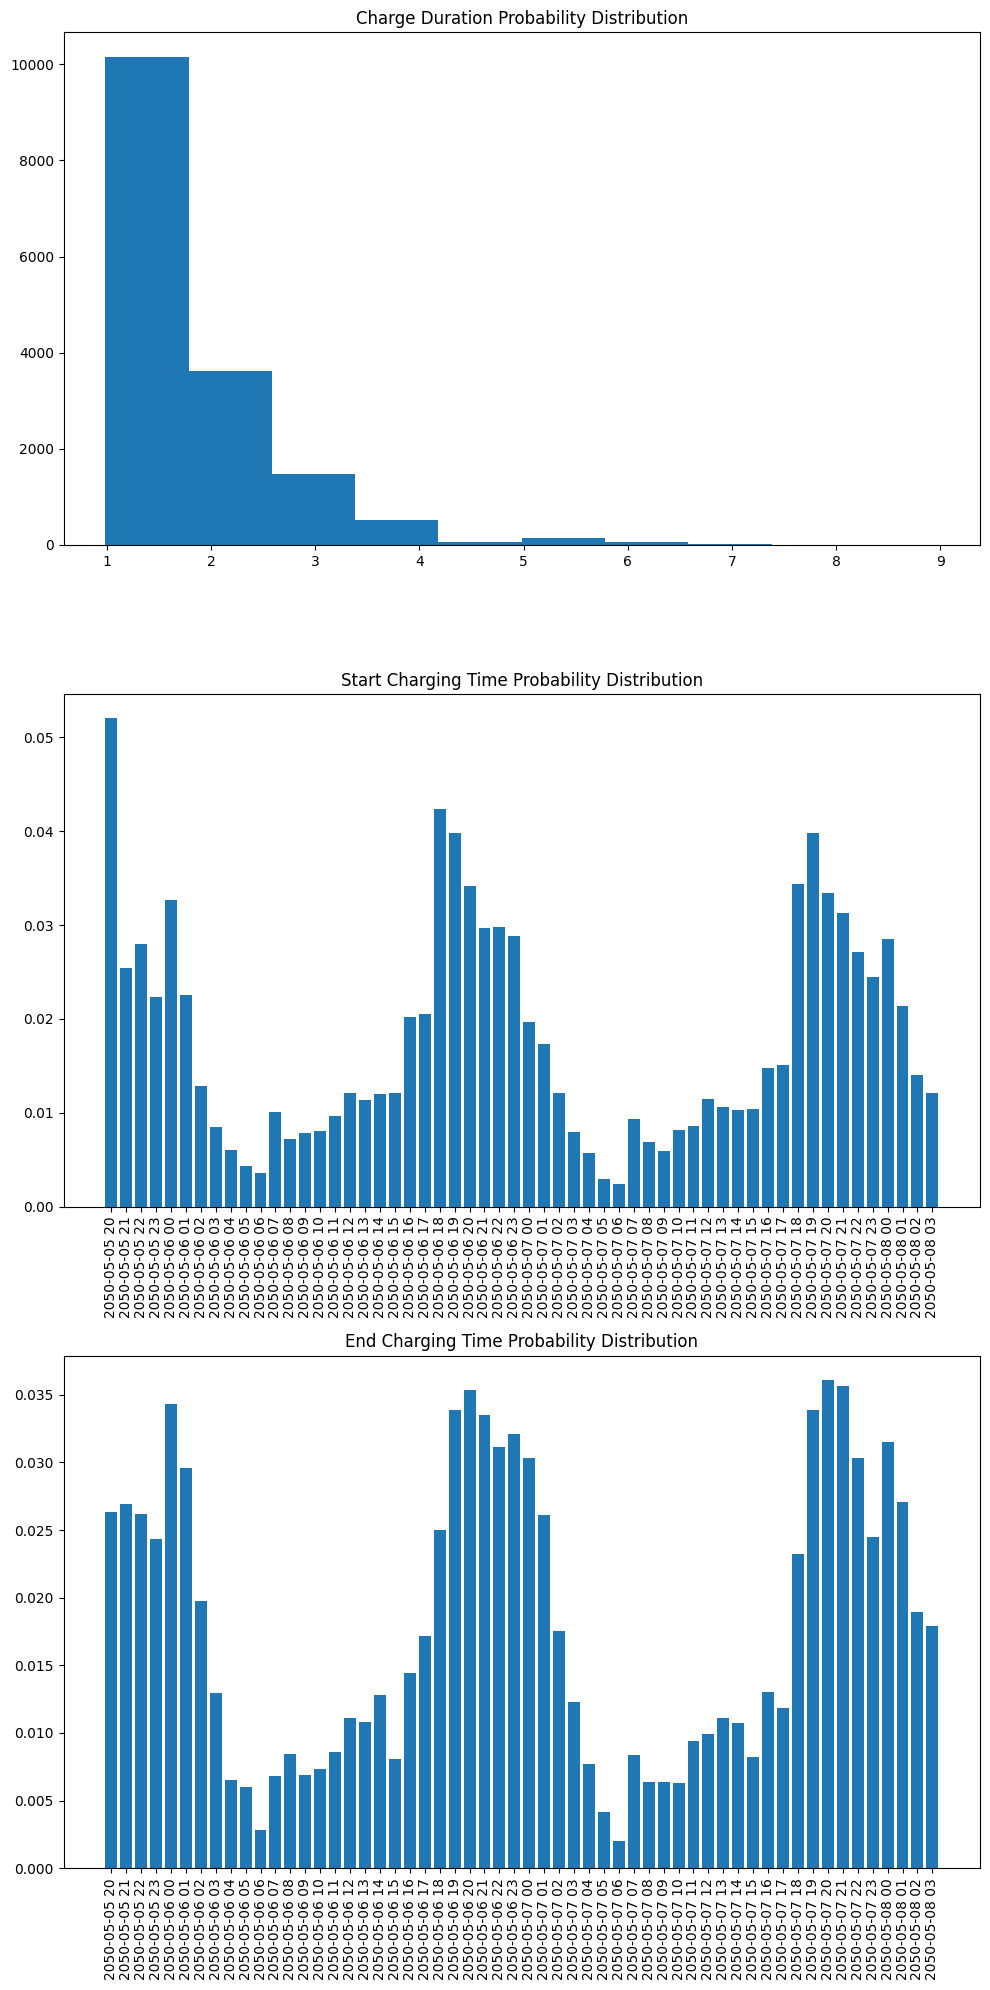

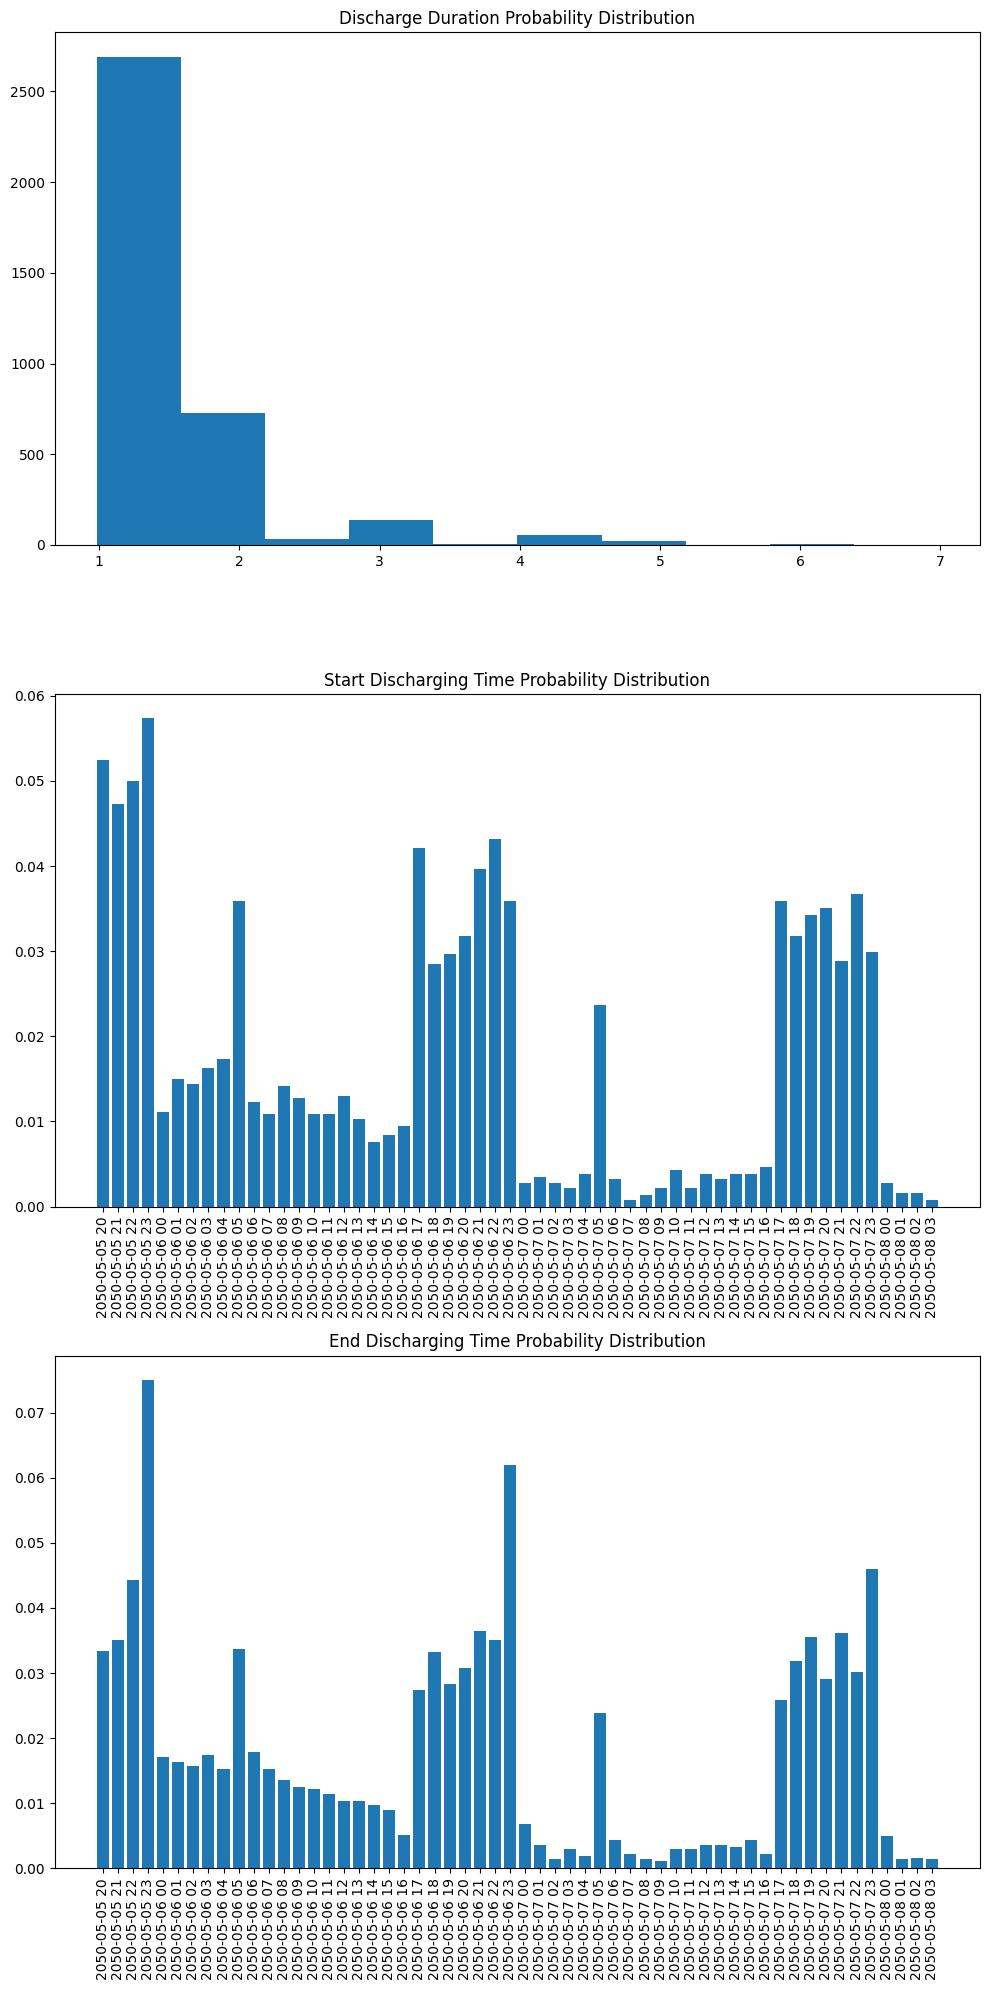

In [35]:
# Start charge hour 
charge = d_in[d_in['optimized_process_mean_power']>0].copy()
charge['st_chg_hour'] = charge['process_list'].apply(lambda x:next(iter((x)))[0].strftime("%Y-%m-%d %H"))
charge['ed_chg_hour'] = charge['process_list'].apply(lambda x:next(iter((x)))[1].strftime("%Y-%m-%d %H"))
charge['chg_durat'] = charge.apply(lambda row: (next(iter(row['process_list']))[1]-next(iter(row['process_list']))[0]).total_seconds()/3600, axis=1)

discharge = d_in[d_in['optimized_process_mean_power']<0].copy()
discharge['st_chg_hour'] = discharge['process_list'].apply(lambda x:next(iter((x)))[0].strftime("%Y-%m-%d %H"))
discharge['ed_chg_hour'] = discharge['process_list'].apply(lambda x:next(iter((x)))[1].strftime("%Y-%m-%d %H"))
discharge['chg_durat'] = discharge.apply(lambda row: (next(iter(row['process_list']))[1]-next(iter(row['process_list']))[0]).total_seconds()/3600, axis=1)

charge_st_stat = charge.groupby('st_chg_hour').size().to_frame('cnt')
charge_st_stat['prob'] = charge_st_stat['cnt']/charge_st_stat['cnt'].sum()
charge_ed_stat = charge.groupby('ed_chg_hour').size().to_frame('cnt')
charge_ed_stat['prob'] = charge_ed_stat['cnt']/charge_ed_stat['cnt'].sum()

dis_st_stat = discharge.groupby('st_chg_hour').size().to_frame('cnt')
dis_st_stat['prob'] = dis_st_stat['cnt']/dis_st_stat['cnt'].sum()
dis_ed_stat = discharge.groupby('ed_chg_hour').size().to_frame('cnt')
dis_ed_stat['prob'] = dis_ed_stat['cnt']/dis_ed_stat['cnt'].sum()

fig, axs = plt.subplots(3, 1, figsize=(10,20))
axs[0].hist(charge['chg_durat'])
axs[0].set_title('Charge Duration Probability Distribution')
axs[1].bar(charge_st_stat.index.astype(str),charge_st_stat['prob'])
axs[1].tick_params(axis='x',labelrotation=90)
axs[1].set_title('Start Charging Time Probability Distribution')
axs[2].bar(charge_ed_stat.index.astype(str),charge_ed_stat['prob'])
axs[2].tick_params(axis='x',labelrotation=90)
axs[2].set_title('End Charging Time Probability Distribution')
plt.tight_layout()
plt.savefig(f"{path}/sanitycheck/charge_time_stats.png")

fig, axs = plt.subplots(3, 1, figsize=(10,20))
axs[0].hist(discharge['chg_durat'])
axs[0].set_title('Discharge Duration Probability Distribution')
axs[1].bar(dis_st_stat.index.astype(str),dis_st_stat['prob'])
axs[1].tick_params(axis='x',labelrotation=90)
axs[1].set_title('Start Discharging Time Probability Distribution')
axs[2].bar(dis_ed_stat.index.astype(str),dis_ed_stat['prob'])
axs[2].tick_params(axis='x',labelrotation=90)
axs[2].set_title('End Discharging Time Probability Distribution')
plt.tight_layout()
plt.savefig(f"{path}/sanitycheck/discharge_time_stats.png")

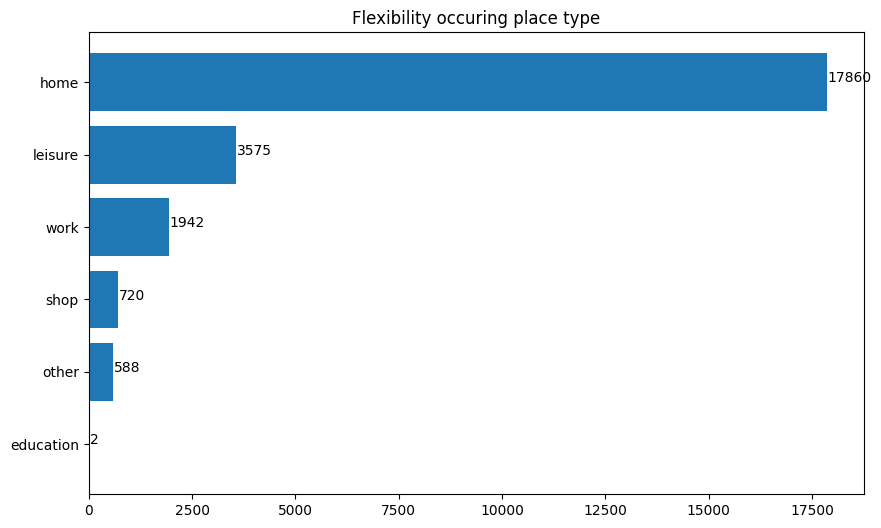

In [51]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
flex_occur_place = flex_d_in.groupby('end_activity_type').size().to_frame('place_cnt')
flex_occur_place_sorted = flex_occur_place.sort_values('place_cnt',ascending=True)
axs.barh(flex_occur_place_sorted.index,flex_occur_place_sorted['place_cnt'])
for index, value in enumerate(flex_occur_place_sorted['place_cnt']):
    plt.text(value+20, index,str(value))
plt.title('Flexibility occuring place type')
plt.savefig(f"{path}/sanitycheck/flex_occuring_place_type.png")

In [52]:
d_in.head(100)[['charge_power_list_sanity','optimized_power_list']]

,charge_power_list_sanity,optimized_power_list
event_index,,
170,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
313,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
388,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
438,"[0.0, 0.0, 11.0, 11.0, 11.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
528,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
529,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
545,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
546,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
576,"[0.0, 0.0, 0.0, 11.0, 11.0, 11.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [58]:
print(len(d.iloc[0].charge_time_list))
print(len(d.iloc[0].charge_power_list_sanity))
# print(len(d_in.iloc[0].optimized_power_list))
print(len(d.iloc[0].hourly_time_dict))




24
24
24
